In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
#|default_exp agents.dqn.basic

In [32]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.fastai.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.jupyter_visualizers import *
from fastrl.learner.core import *

# DQN Basic
> Core DQN modules, pipes, and tooling

## Model

In [5]:
#|export
class DQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)


## Agent

In [39]:
#|export
def DQNAgent(
    model,
    logger_bases=None,
    min_epsilon=0,
    max_epsilon=1,
    max_steps=1000
)->AgentHead:
    agent = AgentBase(model)
    agent = StepFieldSelector(agent,field='state')
    agent = SimpleModelRunner(agent)
    agent = ArgMaxer(agent)
    selector = EpsilonSelector(agent,min_epsilon=min_epsilon,max_epsilon=max_epsilon,max_steps=max_steps)
    agent = EpsilonCollector(selector,logger_bases)
    agent = ArgMaxer(agent,only_idx=True)
    agent = NumpyConverter(agent)
    agent = PyPrimativeConverter(agent)
    agent = AgentHead(agent)
    return agent

In [8]:
from fastrl.envs.gym import *

In [26]:
# Setup Logger
logger_base = ProgressBarLogger()

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)

agent = DQNAgent(model,[logger_base])

block = DataBlock(
    blocks = GymTransformBlock(agent)
)
dls = L(block.dataloaders(['CartPole-v1']*1,n=10,bs=1))

list(dls[0])

[[SimpleStep(state=tensor([[-0.0279, -0.0214,  0.0446, -0.0023]]), action=tensor([1.]), next_state=tensor([[-0.0283,  0.1731,  0.0445, -0.2806]]), terminated=tensor([False]), truncated=tensor([False]), reward=tensor([1.]), total_reward=tensor([1.]), env_id=tensor([140428227683792]), proc_id=tensor([89]), step_n=tensor([1]), episode_n=tensor([1]), image=tensor([[0.]]))],
 [SimpleStep(state=tensor([[-0.0283,  0.1731,  0.0445, -0.2806]]), action=tensor([0.]), next_state=tensor([[-0.0248, -0.0226,  0.0389,  0.0258]]), terminated=tensor([False]), truncated=tensor([False]), reward=tensor([1.]), total_reward=tensor([2.]), env_id=tensor([140428227683792]), proc_id=tensor([89]), step_n=tensor([2]), episode_n=tensor([1]), image=tensor([[0.]]))],
 [SimpleStep(state=tensor([[-0.0248, -0.0226,  0.0389,  0.0258]]), action=tensor([1.]), next_state=tensor([[-0.0253,  0.1719,  0.0394, -0.2544]]), terminated=tensor([False]), truncated=tensor([False]), reward=tensor([1.]), total_reward=tensor([3.]), env_

## Training DataPipes

In [11]:
#|export
class QCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,discount=0.99,nsteps=1):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.learner = find_pipe_instance(self,LearnerBase)
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            
            self.learner.next_q = self.learner.model(batch.next_state)
            # print(self.learner.next_q,self.learner.done_mask)
            self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
            self.learner.next_q[self.learner.done_mask] = 0 #xb[done_mask]['reward']
            self.learner.targets = batch.reward+self.learner.next_q*(self.discount**self.nsteps)
            self.learner.pred = self.learner.model(batch.state)
            
            t_q=self.learner.pred.clone()
            t_q.scatter_(1,batch.action.long(),self.learner.targets)
            
            self.learner.loss_grad = self.learner.loss_func(self.learner.pred, t_q)
            yield batch

In [27]:
#|export
class ModelLearnCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        self.learner = find_pipe_instance(self,LearnerBase)
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.loss_grad.backward()
            self.learner.opt.step()
            self.learner.opt.zero_grad()
            self.learner.loss = self.learner.loss_grad.clone()
            yield self.learner.loss

In [28]:
#|export
class StepBatcher(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        "Converts multiple `StepType` into a single `StepType` with the fields concated."
        self.source_datapipe = source_datapipe
        
    def __iter__(self):
        for batch in self.source_datapipe:
            # print(batch)
            cls = batch[0].__class__
            yield cls(
                **{
                    fld:torch.vstack(tuple(getattr(step,fld) for step in batch)) for fld in cls._fields
                }
            )

In [29]:
#|export
class EpisodeCollector(LogCollector):
    def __iter__(self):
        for q in self.main_queues: q.put(Record('episode',None))
        for steps in self.source_datapipe:
            if isinstance(steps,dp.DataChunk):
                for step in steps:
                    for q in self.main_queues: q.put(Record('episode',step.episode_n.detach().numpy()[0]))
            else:
                for q in self.main_queues: q.put(Record('episode',steps.episode_n.detach().numpy()[0]))
            yield steps

In [30]:
#|export
class LossCollector(LogCollector):
    def __init__(self,
         source_datapipe, # The parent datapipe, likely the one to collect metrics from
         logger_bases:List[LoggerBase] # `LoggerBase`s that we want to send metrics to
        ):
        self.source_datapipe = source_datapipe
        self.main_queues = [o.main_queue for o in logger_bases]
        self.learner = find_pipe_instance(self,LearnerBase)
        
    def __iter__(self):
        for q in self.main_queues: q.put(Record('loss',None))
        for steps in self.source_datapipe:
            for q in self.main_queues: q.put(Record('loss',self.learner.loss.detach().numpy()))
            yield steps

In [31]:
#|export
class RollingTerminatedRewardCollector(LogCollector):
    def __init__(self,
         source_datapipe, # The parent datapipe, likely the one to collect metrics from
         logger_bases:List[LoggerBase], # `LoggerBase`s that we want to send metrics to
         rolling_length:int=100
        ):
        self.source_datapipe = source_datapipe
        self.main_queues = [o.main_queue for o in logger_bases]
        self.rolling_rewards = deque([],maxlen=rolling_length)
        
    def step2terminated(self,step): return bool(step.terminated)
    def __iter__(self):
        for q in self.main_queues: q.put(Record('rolling_reward',None))
        for steps in self.source_datapipe:
            if isinstance(steps,dp.DataChunk):
                for step in steps:
                    if self.step2terminated(step):
                        self.rolling_rewards.append(step.total_reward.detach().numpy()[0])
                        for q in self.main_queues: q.put(Record('rolling_reward',np.average(self.rolling_rewards)))
            elif self.step2terminated(steps):
                self.rolling_rewards.append(steps.total_reward.detach().numpy()[0])
                for q in self.main_queues: q.put(Record('rolling_reward',np.average(self.rolling_rewards)))
            yield steps

In [35]:
#|export
def DQNLearner(
    model,
    dls,
    logger_bases=None,
    loss_func=MSELoss(),
    opt=AdamW,
    lr=0.005,
    bs=128,
    max_sz=10000
) -> LearnerHead:
    learner = LearnerBase(model,dls,loss_func=MSELoss(),opt=opt(model.parameters(),lr=lr))
    learner = BatchCollector(learner,logger_bases=logger_bases,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner,logger_bases=logger_bases)
    for logger_base in logger_bases: learner = logger_base.connect_source_datapipe(learner)
    learner = RollingTerminatedRewardCollector(learner,logger_bases)
    learner = EpisodeCollector(learner,logger_bases)
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner)
    learner = QCalc(learner)
    learner = ModelLearnCalc(learner)
    learner = LossCollector(learner,logger_bases)
    learner = LearnerHead(learner)
    return learner

In [38]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base])
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent)
)
dls = L(block.dataloaders(['CartPole-v1']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base])
# learner.fit(3)
learner.fit(30)

loss,episode,rolling_reward,epoch,batch,epsilon
0.34858134,28,36.185184,1,999,0
0.28490674,36,57.114285,2,999,0
0.38648385,39,67.710526,3,999,0
0.32749584,43,94.690475,4,999,0
0.23164584,48,103.319145,5,999,0
0.23098616,56,108.472725,6,999,0
0.20389733,62,113.09836,7,999,0
0.20151122,68,117.731346,8,999,0
0.23014158,73,124.56944,9,999,0
0.1481072,79,127.24359,10,999,0


In [18]:
from fastrl.loggers.jupyter_visualizers import *

In [19]:
model.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [20]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

In [21]:
%matplotlib inline

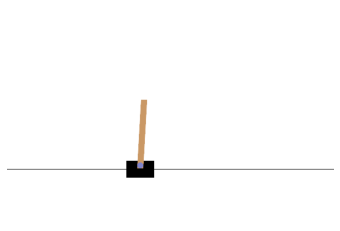

In [23]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['CartPole-v1'],100,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

L(pipe);

In [37]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(8,4)
# Setup the Agent
agent = DQNAgent(model,[logger_base])
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent)
)
dls = L(block.dataloaders(['LunarLander-v2']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base])
learner.fit(3)
# learner.fit(30)

loss,episode,rolling_reward,epoch,batch,epsilon
0.8848638,9,-181.63583,1,999,0
0.56011456,10,-163.04929,2,999,0
1.1071787,11,-174.40005,2,999,0


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

In [ ]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['LunarLander-v2'],1000,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

L(pipe);

In [40]:
#|hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()

/opt/conda/lib/python3.7/site-packages/astroid/node_classes.py:96: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  DeprecationWarning,
